In [23]:
import pandas as pd
import numpy as np
from helpers import plot_histograms

data_path = "tahkeer_data.csv"
all_data = pd.read_csv(data_path)

columns = all_data.columns.tolist()[1:]
columns.remove("smoking")

# Feature engineering
## 1. Remove outliers

In [24]:
columns_to_remove_outliers = {
    "weight(kg)": [30, 120],
    "HDL": [20, 110],
    "triglyceride": [0, 410],
    "fasting blood sugar": [50, 200],
    "Cholesterol": [80, 320],
    "LDL": [0, 260],
    "AST": [0, 100],
    "Gtp": [0, 230],
    "eyesight(left)": [0, 2],
    "waist(cm)": [50, 120],
    "serum creatinine": [0, 2],
    "systolic": [80, 170],
}

for column_name, values in columns_to_remove_outliers.items():
    min_value = values[0]
    max_value = values[1]
    all_data = all_data[(all_data[column_name] >= min_value) & (all_data[column_name] <= max_value)]

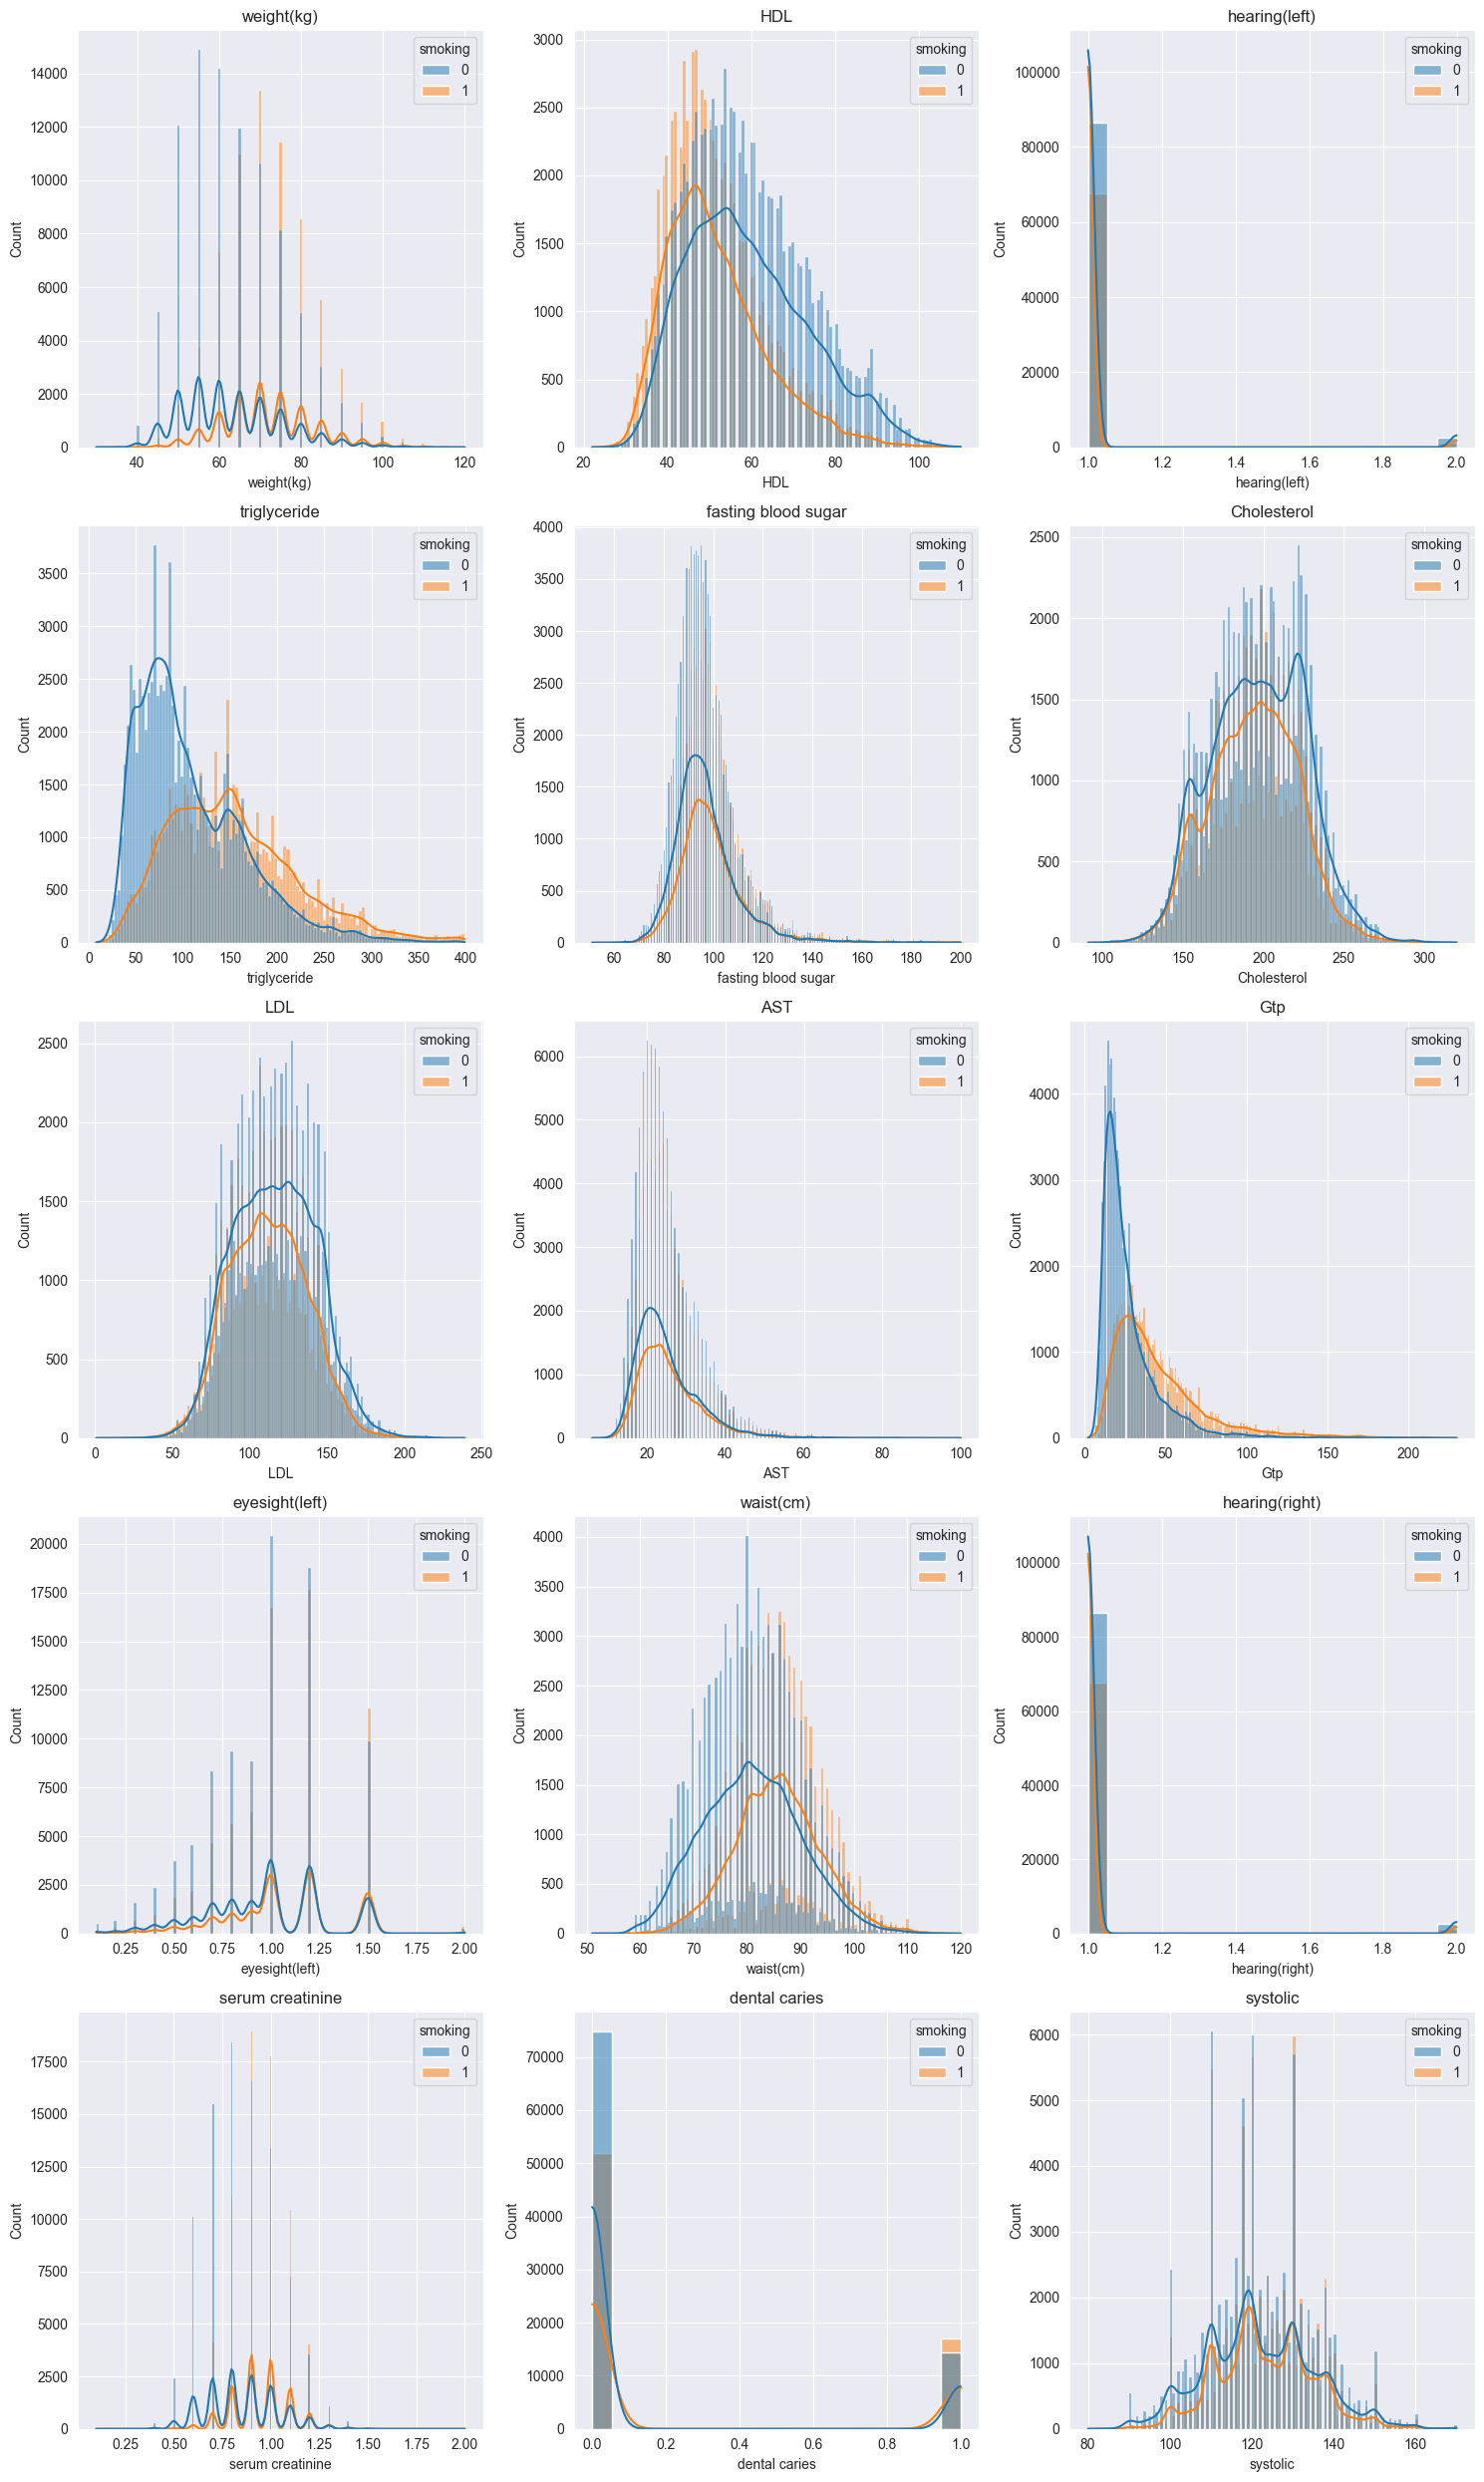

In [25]:
plot_histograms(all_data, columns, 3)

## 2. Apply log

In [26]:
logged_columns = ['Gtp', 'triglyceride', 'AST', 'LDL', 'Cholesterol', 'serum creatinine']

for column in logged_columns:
    all_data[column] = np.log(all_data[column])

## 3. Min-Max normalization
We will use min-max normalization to normalize the data to the range [0, 1]
to reduce the effect of large values on the model.

In [27]:
for column in columns:
    min_value = all_data[column].min()
    max_value = all_data[column].max()
    all_data[column] = (all_data[column] - min_value) / (max_value - min_value)

plot_histograms(all_data, columns, 3)

## 4. Combine features

In [28]:
weight = "weight(kg)"
waist = "waist(cm)"
all_data[weight + "_" + waist + "_interaction"] = all_data[weight] * all_data[waist]
columns.append(weight + "_" + waist + "_interaction")
columns.remove(weight)
columns.remove(waist)

cholesterol = "Cholesterol"
ldl = "LDL"
all_data[cholesterol + "_" + ldl + "_aggregation"] = all_data[[cholesterol, ldl]].mean(axis=1)
columns.append(cholesterol + "_" + ldl + "_aggregation")
columns.remove(cholesterol)
columns.remove(ldl)

## 5. Feature selection

In [29]:
from sklearn.ensemble import RandomForestClassifier

# Assuming 'X' contains your features and 'y' contains the target variable
model = RandomForestClassifier(random_state=42)
model.fit(all_data[columns].values, all_data['smoking'].values)

feature_importance = model.feature_importances_
feature_importance = pd.DataFrame({'feature': columns, 'importance': feature_importance})
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

In [30]:
print(feature_importance)

                             feature  importance
5                                Gtp    0.166255
2                       triglyceride    0.136863
11  weight(kg)_waist(cm)_interaction    0.123681
12       Cholesterol_LDL_aggregation    0.110748
0                                HDL    0.088908
8                   serum creatinine    0.084908
3                fasting blood sugar    0.078540
10                          systolic    0.076366
4                                AST    0.071757
6                     eyesight(left)    0.045711
9                      dental caries    0.010520
1                      hearing(left)    0.002876
7                     hearing(right)    0.002867


In [31]:
threshold = 0.05
useful_features = feature_importance[feature_importance['importance'] > threshold]['feature'].tolist()

print("Useful features: " + str(useful_features))

Useful features: ['Gtp', 'triglyceride', 'weight(kg)_waist(cm)_interaction', 'Cholesterol_LDL_aggregation', 'HDL', 'serum creatinine', 'fasting blood sugar', 'systolic', 'AST']


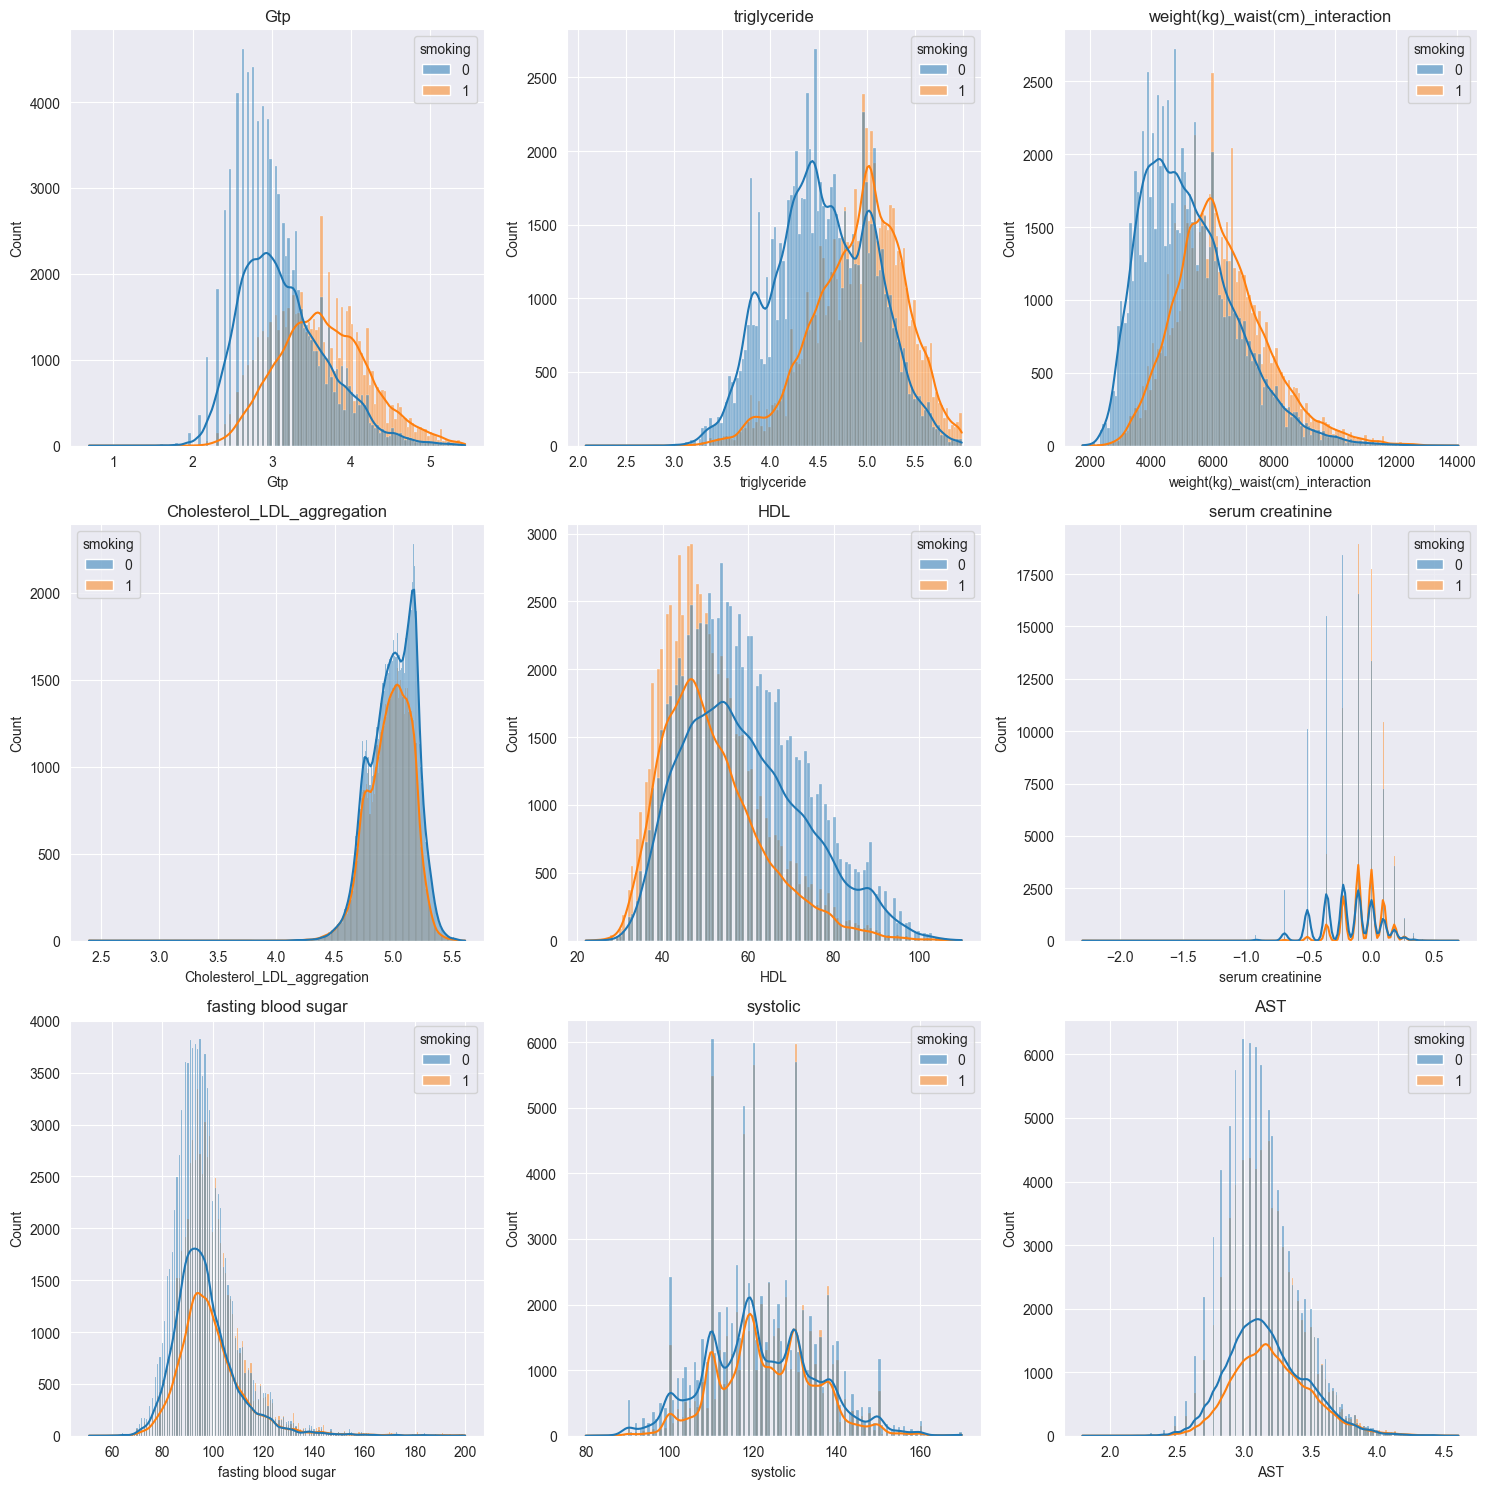

In [32]:
plot_histograms(all_data, useful_features, 3)

In [33]:
all_data = all_data[useful_features + ['smoking']]

all_data.to_csv("tahkeer_data_cleaned.csv", index=False)